In [1]:
# Ignorar avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [3]:
# Carregando os dados
# Baixe o data frame em: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk
caminho_dados = r'C:\Users\Matheus Fabiao\Desktop\TCC-IA-MERCADO-FINANCEIRO\data\risco_credito.csv'
base_dados = pd.read_csv(caminho_dados)

In [4]:
# Faz uma cópia dos dados para manter a base original intacta
dados = base_dados.copy()

In [5]:
# Exibindo as primeiras linhas dos dados
dados.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
# Exibindo informações sobre o DataFrame
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [7]:
# Resumindo estatísticas descritivas do DataFrame
dados.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [8]:
# Contando valores nulos em cada coluna do DataFrame 'dados'
dados.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

<Axes: >

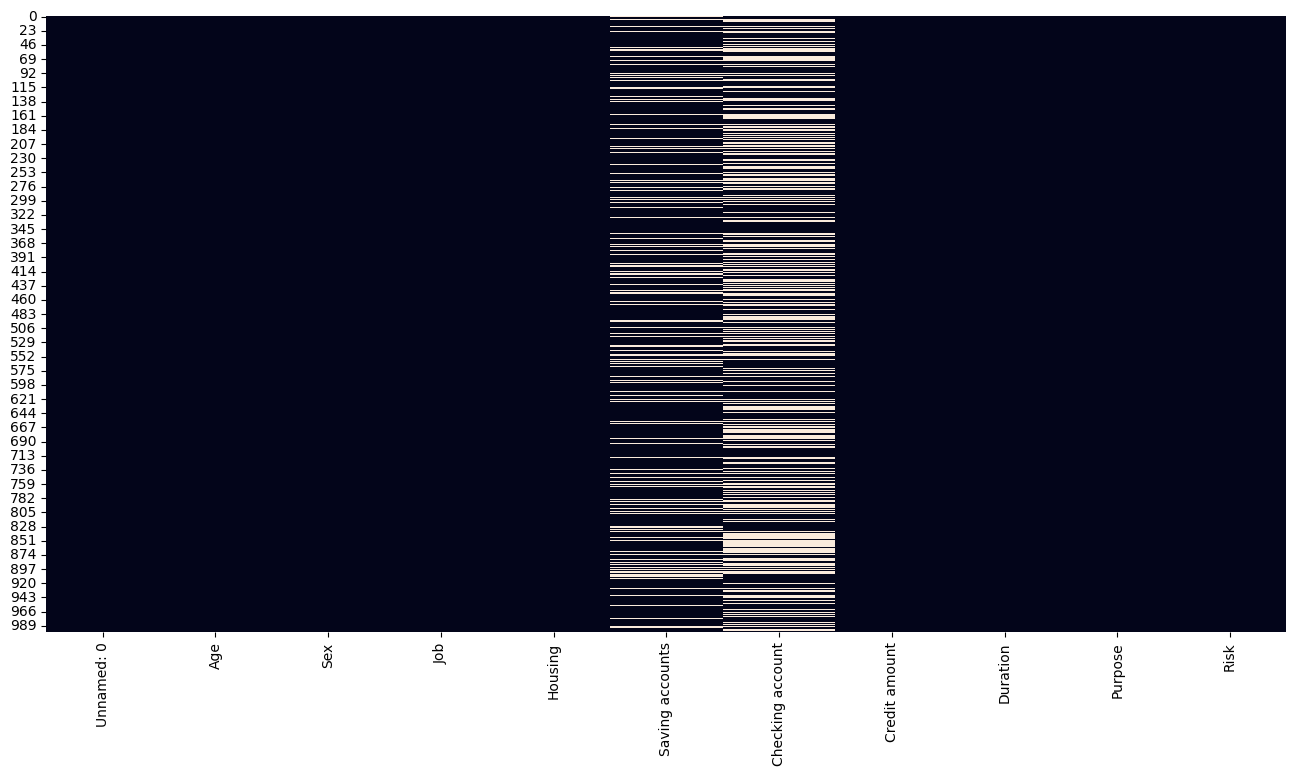

In [9]:
# Plotando um mapa de calor para visualizar valores nulos nos dados
plt.figure(figsize=(16, 8))
sns.heatmap(base_dados.isnull(), cbar=False)

In [10]:
# Removendo a coluna 'Unnamed: 0', por não ser relevante
dados.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [11]:
# Para encontrar a idade mínima e máxima:
idade_minima = dados['Age'].min()
idade_maxima = dados['Age'].max()

# Não há idades negativas no DataFrame
# Não aparenta ter outliers neste coluna
print(f"Idade mínima: {idade_minima}")
print(f"Idade máxima: {idade_maxima}")

Idade mínima: 19
Idade máxima: 75


In [12]:
# Preenchendo valores nulos em 'Saving accounts' e 'Checking account' com 'none'
dados["Saving accounts"] = dados["Saving accounts"].fillna("none")
dados["Checking account"] = dados["Checking account"].fillna("none")

In [13]:
# Engenharia de faixas etárias
intervalos = [0, 30, 40, 50, 60, 120]
rotulos = ["Young", "Adult", "Middle-aged", "Elderly", "Very elderly"]
dados["Age_Group"] = pd.cut(dados["Age"], bins=intervalos, labels=rotulos)

In [14]:
# Engenharia de duração do empréstimo
bins = [0, 12, 24, 36, 48, 60, 120]
labels = ["Short Term", "Medium Term", "Long Term", "Very Long Term", "Maximum Term", "Indefinite"]
dados["Loan_Duration"] = pd.cut(dados["Duration"], bins=bins, labels=labels)

In [15]:
# Razão entre "Credit amount" e "Duration"
dados["Repayment_rate"] = dados["Credit amount"] / dados["Duration"]

In [16]:
# Codificação one-hot para variáveis categóricas
dados = pd.get_dummies(dados, columns=["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose", "Age_Group", "Loan_Duration"])

In [17]:
# Exibindo as últimas linhas dos dados após a engenharia de recursos e codificação
dados.tail()

,Age,Credit amount,Duration,Risk,Repayment_rate,Sex_female,Sex_male,Job_0,Job_1,Job_2,...,Age_Group_Adult,Age_Group_Middle-aged,Age_Group_Elderly,Age_Group_Very elderly,Loan_Duration_Short Term,Loan_Duration_Medium Term,Loan_Duration_Long Term,Loan_Duration_Very Long Term,Loan_Duration_Maximum Term,Loan_Duration_Indefinite
995,31,1736,12,good,144.666667,True,False,False,True,False,...,True,False,False,False,True,False,False,False,False,False
996,40,3857,30,good,128.566667,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
997,38,804,12,good,67.000000,False,True,False,False,True,...,True,False,False,False,True,False,False,False,False,False
998,23,1845,45,bad,41.000000,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
999,27,4576,45,good,101.688889,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [18]:
# Separe as colunas categóricas
colunas_categoricas = dados.select_dtypes(exclude=['int64', 'float64'])

In [19]:
# Aplicando a codificação LabelEncoder
le = LabelEncoder()
for coluna in colunas_categoricas:
    dados[coluna]=le.fit_transform(dados[coluna])

In [20]:
# Separando os dados em atributos (x) e rótulos (y)
x = dados.drop(['Risk'], axis=1)
y = dados['Risk']

In [21]:
# Aplicando a técnica de oversampling SMOTE para balancear as classes
smote = SMOTE(random_state=42)
x_reamostrado, y_reamostrado = smote.fit_resample(x, y)

In [22]:
# Exibindo a contagem de rótulos após o SMOTE
# Equilíbrio entre a minoritária e majoritária
y_reamostrado.value_counts()

Risk
1    700
0    700
Name: count, dtype: int64

In [23]:
# Dividindo os dados em conjuntos de treinamento e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_reamostrado, y_reamostrado, test_size=0.2, random_state=42)

In [24]:
# Normalizando os dados usando StandardScaler
normalizador = StandardScaler()
x_treino = normalizador.fit_transform(x_treino)
x_teste = normalizador.transform(x_teste)

In [25]:
# Treinando o modelo de Random Forest
modelo = RandomForestClassifier(n_estimators=500)
modelo.fit(x_treino, y_treino)

RandomForestClassifier(n_estimators=500)

In [26]:
# Realizando previsões com o modelo
previsao = modelo.predict(x_teste)

In [27]:
# Avaliação do modelo

# Calculando a acurácia
acuracia = accuracy_score(y_teste, previsao)
print(f"Acurácia: {acuracia:.2f}")

# Calculando a precisão
precisao = precision_score(y_teste, previsao)
print(f'Precisão: {precisao:.2f}')

# Calculando o recall
recall = recall_score(y_teste, previsao)
print(f'Recall: {recall:.2f}')

# Calculando o F1 Score
f1 = f1_score(y_teste, previsao)
print(f'F1 Score: {f1:.2f}')

Acurácia: 0.81
Precisão: 0.84
Recall: 0.79
F1 Score: 0.82


In [28]:
# Matriz de Confusão (avaliação visual do desempenho do modelo)
confusion = confusion_matrix(y_teste, previsao)
print("Matriz de Confusão:")
print(confusion)

Matriz de Confusão:
[[109  22]
 [ 31 118]]


In [29]:
# Classification Report (resumo das métricas de classificação)
print("Classification Report:")
print(classification_report(y_teste, previsao))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       131
           1       0.84      0.79      0.82       149

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280



In [30]:
# Validação cruzada
pontuacoes_validacao_cruzada = cross_val_score(estimator=modelo, X=x_treino, y=y_treino, cv=10)
print("Média da Validação Cruzada:", pontuacoes_validacao_cruzada.mean())

Média da Validação Cruzada: 0.8348214285714285


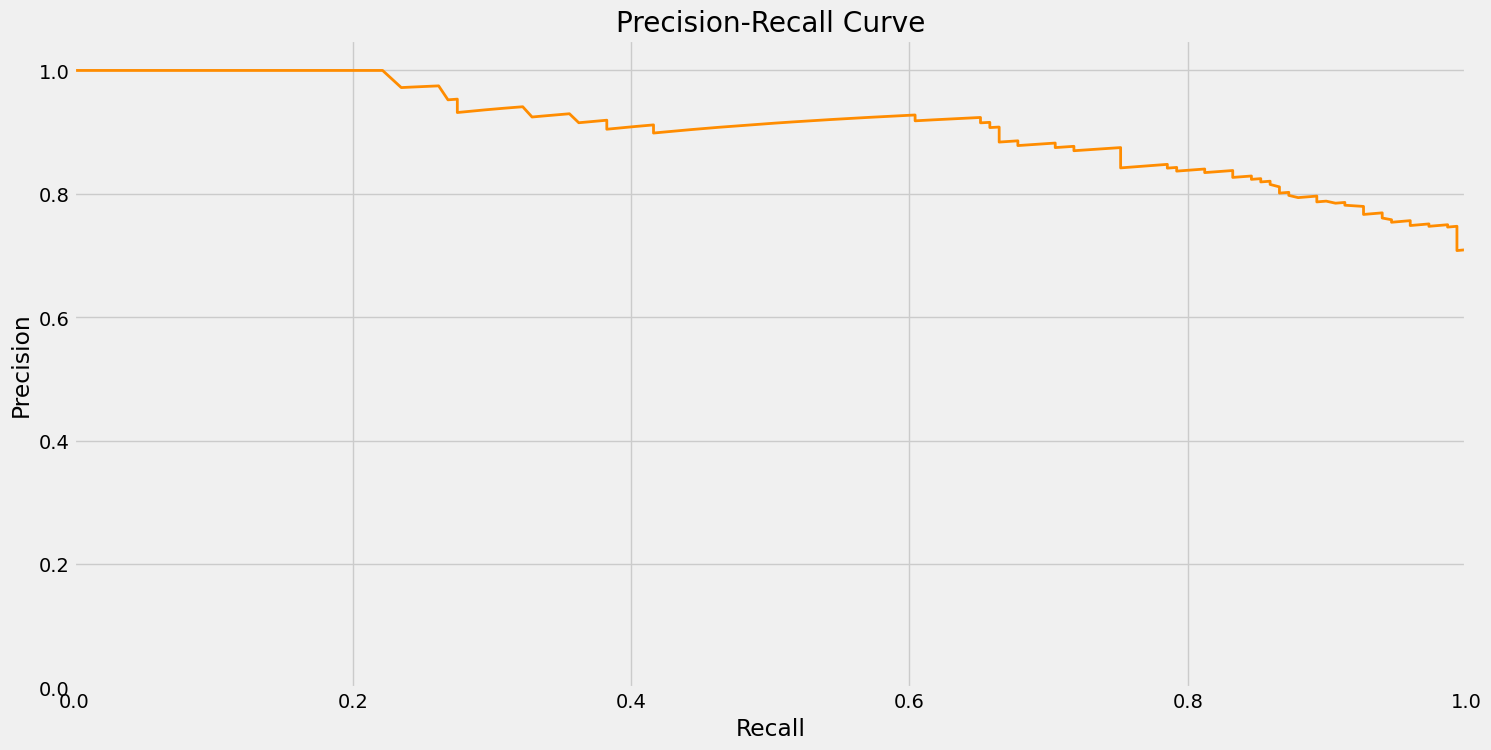

In [31]:
# Precision-Recall Curve (trade-off entre precisão e recall)
precision, recall, thresholds = precision_recall_curve(y_teste, modelo.predict_proba(x_teste)[:, 1])
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

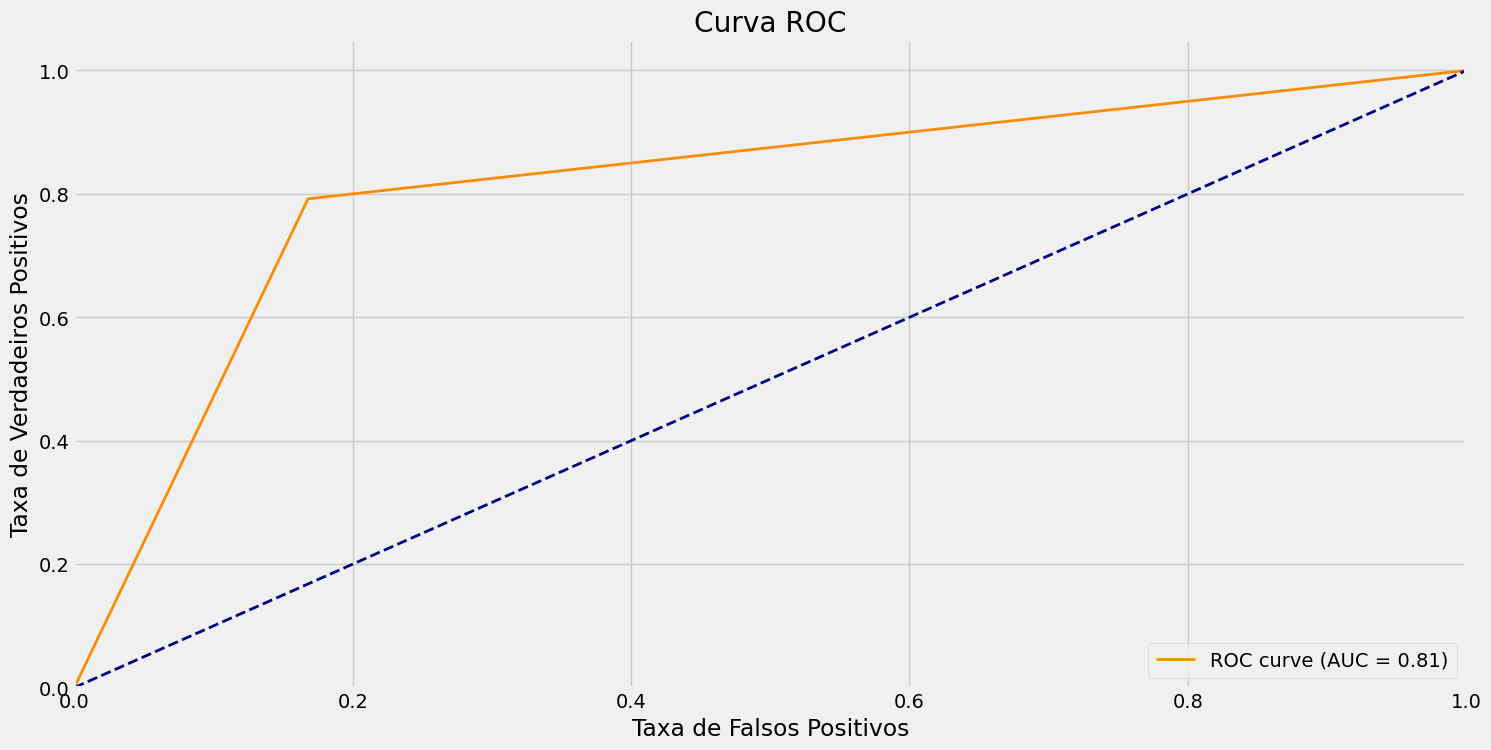

In [32]:
# Calculando a Curva ROC
fpr, tpr, thresholds = roc_curve(y_teste, previsao)
# Calculando a Área sob a Curva ROC (AUC)
roc_auc = auc(fpr, tpr)
# Plotando a Curva ROC
plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()